# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. **Calculate strain**
7. Visualize strain maps

# Notebook 6: Calculate strain

In this step the strain is calculated from the lattice vectors at each scan position.

* Get reference lattice(s)
    * Segment diffraction patterns
    * Within each segmentation region, calculate average lattice vectors
* For each diffraction pattern:
    * Calculate strain with respect to reference lattice

## Computing strain

Here we briefly review the linear algebra used to calculate strain here.  

We can write a pair of lattice vectors $\mathbf{u'},\mathbf{v'}$ which have been distorted some amount relative to a pair of undistored, reference lattice vectors $\mathbf{u},\mathbf{v}$ as a linear transformation:

\begin{align}
\begin{pmatrix}
u_x'   &   v_x'   \\
u_y'   &   v_y'
\end{pmatrix}
&=
\begin{pmatrix}
a  &   b   \\
c  &   d
\end{pmatrix}
\begin{pmatrix}
u_x   &   v_x   \\
u_y   &   v_y
\end{pmatrix}  \\
\end{align}

Here, the effect of $a$ and $d$ is stretching or compression along the $x$ and $y$ directions, respectively, while the effect of $c$ and $d$ is shearing.  Below we denote this as $\beta = A\beta_0$, where $\beta$ and $\beta_0$ are the final and reference lattice vector matrices, respectively, and $A$ is the transformation matrix.  Note that to use numpy.linalg.lstsq to solve for $T$, we'll rearrange this to $\beta = \beta_0^TA^T$.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time
from gc import collect
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.filters import maximum_filter
from scipy.signal import medfilt

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray

In [2]:
# # Load the raw data
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_diffraction_shift_corrected.h5"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# # Load the lattice vectors maps
# fp_uvmap = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vector_maps.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
# browser.show_dataobjects()
# uv_map = browser.get_dataobject(0)

# # Load the DF image
# fp_DFimage = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/DF_image.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
# browser.show_dataobjects()
# DF_image = browser.get_dataobject(0)

In [3]:
# Load the raw data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(47,57)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# Load the lattice vectors maps
fp_uvmap = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vector_maps.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
browser.show_dataobjects()
uv_map = browser.get_dataobject(0)

# Load the DF image
fp_DFimage = "/home/ben/Data/20180905_FePO4_unlithiated/processing/DF_image.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
browser.show_dataobjects()
DF_image = browser.get_dataobject(0)

Reading file /home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4...

/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4 is not a py4DSTEM file.  Reading with hyperspy...
 Index                  Name                        Type        
   0    realslice_0                         RealSlice           
 Index                  Name                        Type        
   0    realslice_0                         RealSlice           


### Segment

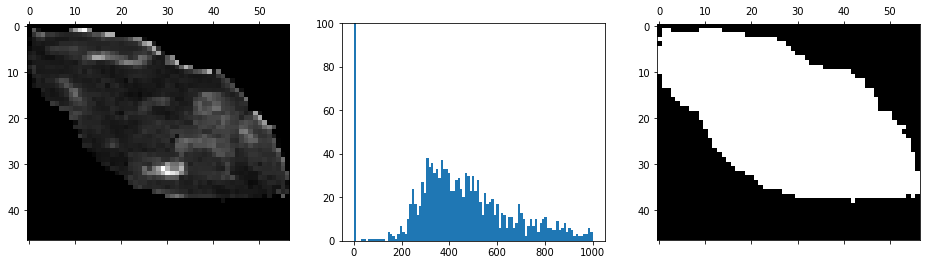

In [4]:
# Make a mask from the virtual dark-field image

mask = (DF_image.data2D>0)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.matshow(DF_image.data2D)
ax2.hist(DF_image.data2D.ravel(),bins=np.linspace(0,1000,100))
ax2.set_ylim([0,100])
ax3.matshow(mask)
plt.show()

### Calculate reference lattice

In [5]:
# Get a reference lattice using median statistics

ux_ref = np.median(uv_map.data2D['ux'][mask])
uy_ref = np.median(uv_map.data2D['uy'][mask])
vx_ref = np.median(uv_map.data2D['vx'][mask])
vy_ref = np.median(uv_map.data2D['vy'][mask])

beta_0 = np.array([[ux_ref, vx_ref],[uy_ref, vy_ref]])

In [6]:
# Get strains

strain_maps = RealSlice(data=np.empty((4,dc.R_Nx,dc.R_Ny)),
                       parentDataCube=dc,
                       slicelabels=('e_xx','e_yy','e_xy','theta'),
                       name="strain_maps")

for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        beta = np.array([[uv_map.data2D['ux'][Rx,Ry],uv_map.data2D['vx'][Rx,Ry]],
                       [uv_map.data2D['uy'][Rx,Ry],uv_map.data2D['vy'][Rx,Ry]]])
        A = lstsq(beta.T,beta_0.T,rcond=None)[0].T
        
        strain_maps.data2D['e_xx'][Rx,Ry] = 1 - A[0,0]
        strain_maps.data2D['e_yy'][Rx,Ry] = 1 - A[1,1]
        strain_maps.data2D['e_xy'][Rx,Ry] = -(A[0,1]+A[1,0])/2.
        strain_maps.data2D['theta'][Rx,Ry] = (A[0,1]-A[1,0])/2.

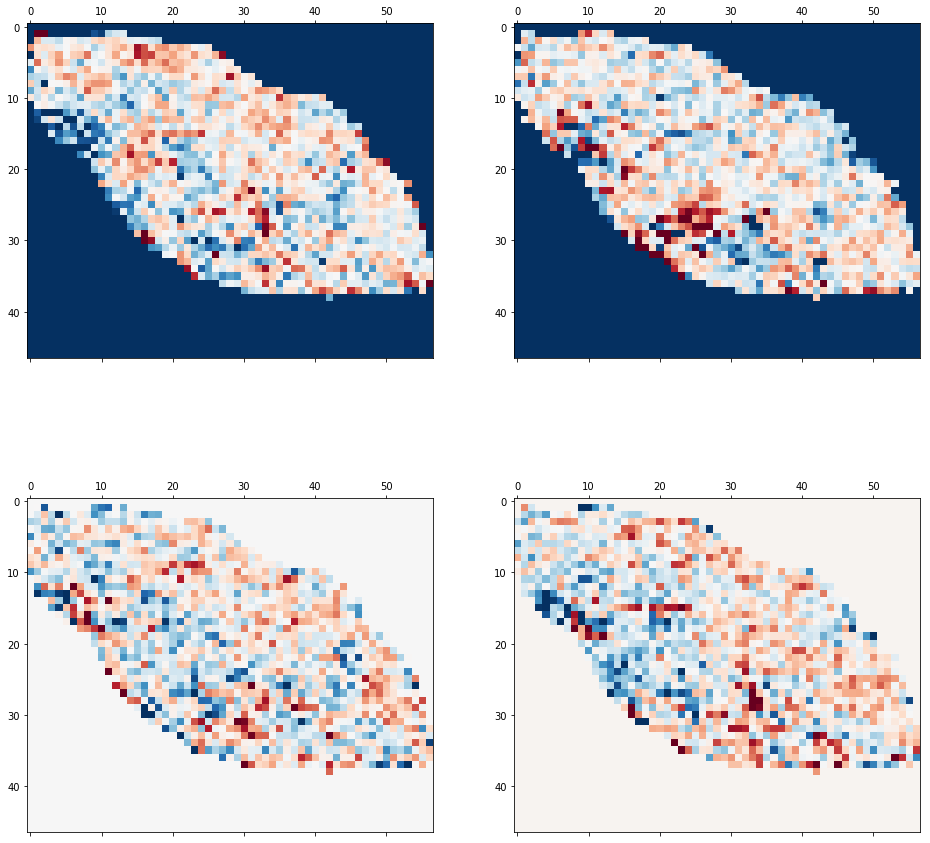

In [7]:
# Plot

n_stds=2.5

e_xx_ave, e_xx_std = np.average(strain_maps.data2D['e_xx'][mask]),np.std(strain_maps.data2D['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_maps.data2D['e_yy'][mask]),np.std(strain_maps.data2D['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_maps.data2D['e_xy'][mask]),np.std(strain_maps.data2D['e_xy'][mask])
theta_ave, theta_std = np.average(strain_maps.data2D['theta'][mask]),np.std(strain_maps.data2D['theta'][mask])

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(16,16))
ax11.matshow(strain_maps.data2D['e_xx'],vmin=-n_stds*e_xx_std, vmax=n_stds*e_xx_std, cmap="RdBu")
ax12.matshow(strain_maps.data2D['e_yy'],vmin=-n_stds*e_yy_std, vmax=n_stds*e_yy_std, cmap="RdBu")
ax21.matshow(strain_maps.data2D['e_xy'],vmin=-n_stds*e_xy_std, vmax=n_stds*e_xy_std, cmap="RdBu")
ax22.matshow(strain_maps.data2D['theta'],vmin=theta_ave-n_stds*theta_std, vmax=theta_ave+n_stds*theta_std, cmap="RdBu")
plt.show()

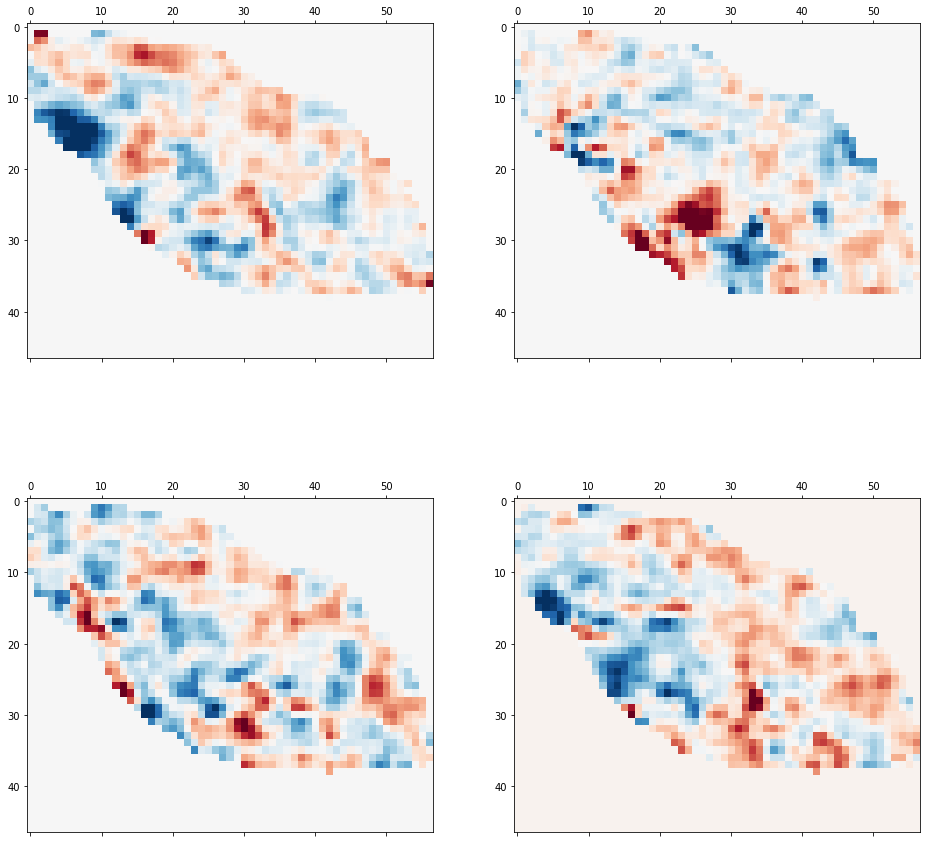

In [8]:
# Plot, with gaussian smoothing

sigma = .8
n_stds=3

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xx'], medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_yy'], medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xy'], medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave, e_xx_std = np.average(e_xx_smoothed[mask]),np.std(e_xx_smoothed[mask])
e_yy_ave, e_yy_std = np.average(e_yy_smoothed[mask]),np.std(e_yy_smoothed[mask])
e_xy_ave, e_xy_std = np.average(e_xy_smoothed[mask]),np.std(e_xy_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(16,16))
ax11.matshow(e_xx_smoothed,vmin=-n_stds*e_xx_std, vmax=n_stds*e_xx_std, cmap="RdBu")
ax12.matshow(e_yy_smoothed,vmin=-n_stds*e_yy_std, vmax=n_stds*e_yy_std, cmap="RdBu")
ax21.matshow(e_xy_smoothed,vmin=-n_stds*e_xy_std, vmax=n_stds*e_xy_std, cmap="RdBu")
ax22.matshow(theta_smoothed,vmin=theta_ave-n_stds*theta_std, vmax=theta_ave+n_stds*theta_std, cmap="RdBu")
plt.show()

### Save strain maps

In [9]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
py4DSTEM.readwrite.save_dataobject(strain_maps,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps.h5...
Writing metadata...
Done.


In [10]:
# # Save

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
# py4DSTEM.readwrite.save_dataobject(strain_maps,savepath)